In [1]:
import os
import io
import datetime
import requests

import numpy as np
import pandas as pd
import geopandas as gp

from tqdm import tqdm

# GET reservoir storage for nearby reservoirs 

In [2]:
def get_res_storage(reservoir_ids):
    '''
    Query CA DWR website to get MONTHLY reservoir storage for an area of interest
    '''
    print("**** Begin Fetching CDEC Reservoir Storage Data****")


    # Download Storage (SensorNums = 15) data by query str:
    start = datetime.datetime(1997, 1, 1)
    end = datetime.datetime(2022, 1, 1)
    dt_idx = pd.date_range(start,end, freq='MS')

    data = {}

    for i in tqdm(reservoir_ids):
        # print("processing " + i )
        url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=1997-01-01&End=2022-01-01".format(i)
        urlData = requests.get(url).content
        df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))

        if df.empty:
            pass
        else:
            data[i] = df

    storage = []
    for k,v in data.items():
        sres = pd.DataFrame(pd.to_numeric(data[k].VALUE, errors = "coerce"))
        sres.columns = [k]
        sres.index = dt_idx
        storage.append(sres)
    
    return pd.concat(storage, axis = 1) 
    

In [3]:
# gdf = gp.read_file("../shape/usgs_gauges.shp")
butte_gwm = gp.read_file("../shape/butte_gw_model.shp").buffer(0.05)
subregion = gp.read_file('../shape/c2vsim_subregion5.shp')
overlap_gdf = subregion.union(butte_gwm)
overlap_gdf = gp.GeoDataFrame(geometry = overlap_gdf)
overlap_gdf.set_crs = "EPSG:4326"

# Spatial join cdec reservoirs to supplied gdf 
reservoirs = gp.read_file("../shape/cdec_reservoirs.shp")
within_gdf = gp.sjoin(reservoirs, overlap_gdf, how='inner')


<ipython-input-3-13de8ec59355>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  butte_gwm = gp.read_file("../shape/butte_gw_model.shp").buffer(0.05)
<ipython-input-3-13de8ec59355>:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  within_gdf.to_file("../shape/study_area/res_within.shp")


In [4]:
res_ids_within = list(within_gdf['ID'])
# res_ids_within.extend(['BUL'])
sres = get_res_storage(res_ids_within)

  0%|          | 0/11 [00:00<?, ?it/s]

**** Begin Fetching CDEC Reservoir Storage Data****


100%|██████████| 11/11 [00:04<00:00,  2.47it/s]


In [5]:
sres_km3 = sres * 1.23348e-6 # acre ft to km^3

In [21]:
sres_km3

,ORO,TMT,TAB,THD,TFR
1997-01-01,3.527816,0.076819,0.049065,0.016256,0.011497
1997-02-01,3.300382,0.069354,0.040648,0.016156,0.012549
1997-03-01,3.653882,0.068359,0.038924,0.015948,0.013488
1997-04-01,3.974805,0.062389,0.033697,0.015698,0.012993
1997-05-01,3.931581,0.076030,0.048254,0.015666,0.012110
...,...,...,...,...,...
2021-09-01,0.971489,0.097135,0.066787,0.016214,0.014137
2021-10-01,1.208426,0.090439,0.060381,0.016114,0.013944
2021-11-01,1.301316,0.099438,0.069618,0.015992,0.013830
2021-12-01,1.676646,0.088617,0.058900,0.015970,0.013746


<AxesSubplot:>

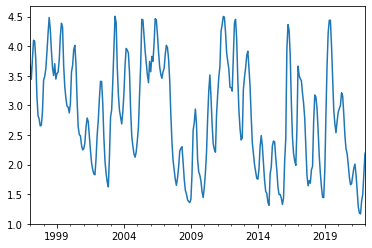

In [7]:
sres_km3.sum(axis = 1).plot()

In [22]:
# Filter for where we have data 
write_gdf= within_gdf[within_gdf['ID'].isin(sres_km3.columns)]

# Write to /shape/study_area
write_gdf.to_file("../shape/study_area/res_within.shp")

<ipython-input-22-cc2864a2345f>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  write_gdf.to_file("../shape/study_area/res_within.shp")


In [8]:
# Write the sum
sres_km3.sum(axis = 1).to_csv("../data/res_stor_km3.csv")

# Write each individual reservoir 
if not os.path.exists("../data/reservoirs"):
    os.mkdir("../data/reservoirs")
sres_km3.to_csv("../data/reservoirs/all_res_km3.csv")

# GET streamflow  for gauges within shapefile

NOTE: Need to preselect the inflow/outflow stations 

API reference found here: https://waterservices.usgs.gov/rest/Statistics-Service-Test-Tool.html


In [9]:
# read stream gauges shapefile 
gauges = gp.read_file("../shape/usgs_gauges.shp")

# Spatial join gauges to study area gdf 
gauges_in_gdf = gp.sjoin(gauges, overlap_gdf, how='inner')
gauge_ids = gauges_in_gdf['gauge_id']


In [10]:
def get_streamflow(gauge_ids):
    
    '''
    Query CA DWR website to get MONTHLY reservoir storage for an area of interest
    '''
    print("**** Begin Fetching USGS STREAmflow Data****")
        
    streamflow_dfs = []

    for site_id in gauge_ids[:]:
        print(site_id)
        
        url = "https://waterservices.usgs.gov/nwis/stat/?format=rdb&sites={}&statReportType=monthly&statTypeCd=all&missingData=off&parameterCd=00060".format(str(site_id))
        try:
            df = pd.read_csv(url, skiprows = 32, sep = '\t').iloc[1:]
            # Get year/month as datetime index 
            df['year_nu'] = df['year_nu'].astype(int)
            df['month_nu'] = df['month_nu'].astype(int)
            df['mean_va'] = df['mean_va'].astype(float)

            dts = []
            for y,m in zip(df['year_nu'], df['month_nu']):
                dts.append(datetime.datetime(y,m,1) )

            df.index = dts            

            # convert cfs to cms, then m3 --> km3 then sec --> month
            df['q_km3_mon'] = df['mean_va'] *0.0283168 * 1e-9 * 2629800
            outdf= pd.DataFrame(df['q_km3_mon'])

            outdf.columns = [site_id]

            streamflow_dfs.append(outdf)
        except:
            print(url)
        
    return pd.concat(streamflow_dfs, axis = 1)
        

In [11]:
# streamflow = get_streamflow(gauge_ids)

In [12]:
# NOTE: IF we count upper sacramento, (11389500), inflow > outflow 
# aa_inflow_stns = ['11424000', '11421000', '11407000', '11406850','11406848','11390000','11389500']
# aa_outflow_stns = ['11389500', '11421000','11425500']
# aa_inflow_stns = ['11424000', '11421000', '11406920' , '11406848', '11390000']
aa_inflow_stns = ['11421000', '11390000','11389500']

# aa_inflow_stns = ['11390000', '11423800']

# aa_inflow_stns = ["11390000", '11406910', '11406920', '11421000', '11424000']
# aa_inflow_stns = ['11421000', '11407000', '11406850','11406848','11390000']

# aa_inflow_stns = ['11390000', '11424000', '11421000','11407000']
aa_outflow_stns = ['11425500']

# aa_outflow_stns = ['11424000']

In [13]:
inflow = get_streamflow(aa_inflow_stns)
outflow = get_streamflow(aa_outflow_stns)

**** Begin Fetching USGS STREAmflow Data****
11421000
11390000
11389500
**** Begin Fetching USGS STREAmflow Data****
11425500


<AxesSubplot:>

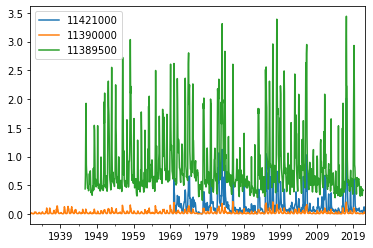

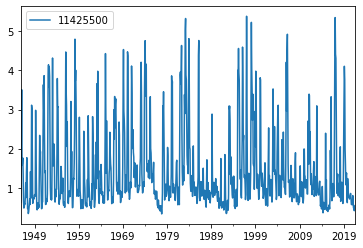

In [14]:
inflow.plot()
outflow.plot()

<AxesSubplot:>

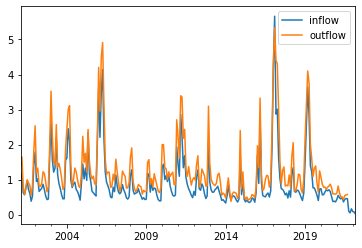

In [15]:
inflow[inflow.index>'2001-01-01'].sum(axis = 1).plot(label = 'inflow', legend = True)
outflow[outflow.index>'2001-01-01'].sum(axis =1).plot(label = 'outflow', legend = True)

In [16]:
indf = pd.DataFrame(inflow[inflow.index>'2001-01-01'].sum(axis = 1))
indf.columns = ['inflow_km3']
outdf = pd.DataFrame(outflow[outflow.index>'2001-01-01'].sum(axis = 1))
outdf.columns = ['outflow_km3']

indf.to_csv("../data/inflow.csv")
outdf.to_csv("../data/outflow.csv")

In [17]:
# Save 
gauges[gauges['gauge_id'].isin(aa_inflow_stns)].to_file("../shape/study_area/inflow.shp")
gauges[gauges['gauge_id'].isin(aa_outflow_stns)].to_file("../shape/study_area/outflow.shp")

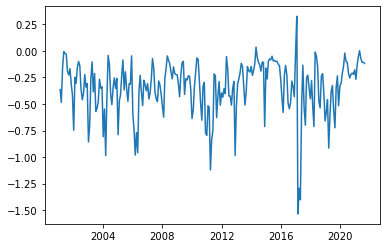

In [18]:
import matplotlib.pyplot as plt
plt.plot(inflow[inflow.index>'2001-01-01'].sum(axis = 1) - outflow[outflow.index>'2001-01-01'].sum(axis = 1))